# Normalize UDS Data

All Universal Decompositional Semantics (UDS) datasets have some amount of redundancy–i.e. each item is annotated by multiple annotators. The aim of this notebook is to produce a single canonical aggregated value for these annotations and to output JSON to be fed to a `decomp.semantics.UDSGraph` object. 

In [1]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from collections import defaultdict

from nltk.corpus import wordnet as wn

from predpatt import load_conllu
from predpatt import PredPatt
from predpatt import PredPattOpts

import matplotlib.pyplot as plt
%matplotlib inline

import json

sess = tf.InteractiveSession()

## Normalizers

Normalization is done using mixed effects models with fixed effects for each annotation object and property and random effects corresponding to each annotator. In principle, we could fit more complex models that account for other effects–e.g. which document an item is found in. Our aim here is to keep the normalization as barebones as possible while adjusting for biases introduced by the annotator, leaving the modeling of other effects to users of the UDS data. 

The main sort of bias we are concerned with is differing uses of the response scales provided to annotators. UDS datasets currently use four sorts of scales: ordinal (1-5), binary (0-1), nominal (e.g. word sense annotations), and bounded interval (e.g. temporal relation annotations). We design two sorts of model-based normalizers to handle the first three, not performing aggregation of the final one.

### Ordinal and Binary Normalizer

The ordinal normalizer is a simple linked logit mixed model with unconstrained annotator cutpoints. When the response scale is binary, this is just a simple logistic mixed model with random intercepts for annotators. In addition to the standard components of these models, we also allow for weights and smoothing. 

The weights are used to weight the loss and will generally be obtained from normalized versions of confidence or applicability ratings that annotators provide–e.g. when an annotator has low confidence, we don't want the response that confidence is associated with the weigh heavily on the normalized. This is the analogue of computing a weighted mean based on the confidences.

The smoothing is eused to ensure that the normalized scores do not cluster around extreme values, which is common when particular items only receive one kind of response. 

In [2]:
def fit_ordinal_normalizer(response, obj, participant, center=True, weights=None, 
                           smoothing=0, iterations=25000, verbose=1000, seed=3029384):
    
    tf.random.set_random_seed(seed)
    
    n = response.shape[0]
    resp_tf = tf.constant(np.array(list(zip(np.arange(n), 
                                            response.astype(np.int32)))))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    try:
        assert nresp > 2 or center
    except AssertionError:
        raise ValueError('must center if only two response types')
    
    normed = tf.Variable(tf.random_normal([nobj], 0, 1e-5))
    
    if not center:
        normed = tf.square(normed)
    
    normed_obj = tf.gather(normed, obj_tf)
    jumps_aux = tf.Variable(tf.random_normal([npart, nresp-1], 0, 1e-5))
    
    if nresp > 2:
        jumps = tf.square(jumps_aux)
        cuts = tf.cumsum(jumps, axis=1)
    else:
        jumps = jumps_aux
        cuts = jumps
    
    if center:
        if nresp > 2:
            mid = np.floor(nresp/2).astype(int)
            cuts_mean = tf.reduce_mean(cuts, axis=0)
            cuts = cuts - cuts_mean[mid]
        else:
            cuts = cuts - tf.reduce_mean(cuts)
        
    cuts_part = tf.gather(cuts, part_tf)
    
    prob_leq = tf.sigmoid(cuts_part-normed_obj[:,None])
    
    prob_leq_high = tf.concat([prob_leq, tf.ones([n, 1])], axis=1)
    prob_leq_low = tf.concat([tf.zeros([n, 1]), prob_leq], axis=1)
    
    probs = tf.gather_nd(prob_leq_high, resp_tf) - tf.gather_nd(prob_leq_low, resp_tf)

    if nresp > 2:
        jumps_norm = jumps/tf.reduce_mean(jumps, axis=0)[None,:]
        prior = tf.reduce_sum(jumps_norm)
    else:
        cuts_std = tf.sqrt(tf.reduce_mean(tf.square(cuts)))
        prior = tf.reduce_sum(tf.square(cuts/cuts_std))
   
    likes_all = tf.log(probs+1e-10)
    
    if weights is not None:
        weights_tf = tf.constant(weights)
        like = tf.reduce_sum(weights_tf*likes_all)
    else:
        like = tf.reduce_sum(likes_all)
    
    loss = -like+prior
    
    if smoothing:
        cuts_mean = tf.reduce_mean(cuts, axis=0)
        
        if nresp > 2:
            for i in range(nresp):
                if i < (nresp - 1):
                    prob_leq_high_mean = tf.sigmoid(cuts_mean[i]-normed)
                else:
                    prob_leq_high_mean = 1

                if i > 0:
                    prob_leq_low_mean = tf.sigmoid(cuts_mean[i-1]-normed)
                else:
                    prob_leq_low_mean = 0

                loss -= tf.reduce_sum(smoothing*tf.log(prob_leq_high_mean-prob_leq_low_mean+1e-10))
        else:
            prob_leq_mean = tf.sigmoid(cuts_mean-normed)
    
            loss -= tf.reduce_sum(smoothing*tf.log(prob_leq_mean+1e-10)+\
                                  smoothing*tf.log(1-prob_leq_mean+1e-10))
    
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    prev_best = np.inf
    
    for i in range(iterations):
        _, lk, pr, l, p = sess.run([train_op, like, prior, loss, probs])
        if not i % verbose:
            print(i, '\t', lk, '\t', pr, '\t', l, '\t', p.mean())
            
    return normed_obj.eval(), likes_all.eval(), jumps.eval(), cuts.eval()

### Nominal Normalizer

The nominal normalizer is a simple mulinomial logit mixed model with annotator biases for each class. We do not use this model for binary responses, since we prefer to normalize to a single value for those responses, and this normalizer would produce two values: one for each of the two classes. Instead, we use the ordinal normalizer for binary responses. The weights and smoothing are analogous to those implemented for the ordinal normalizer.

In [3]:
def fit_multinomial_normalizer(response, obj, participant, weights=None,
                               smoothing=0, iterations=25000, verbose=1000, seed=203948):
    
    tf.random.set_random_seed(seed)
    
    n = response.shape[0]
    resp_tf = tf.constant(np.array(response).astype(np.int32))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    try:
        assert nresp > 2
    except AssertionError:
        raise ValueError('not meant for binary responses')
    
    normed = tf.Variable(tf.random_normal([nobj, nresp], 0, 1e-5))
    
    normed_obj = tf.gather(normed, obj_tf)

    bias_aux = tf.Variable(tf.random_normal([npart, nresp], 0, 1e-5))
    bias = bias_aux - tf.reduce_mean(bias_aux, axis=0)[None,:]
    bias_part = tf.gather(bias, part_tf)
    
    bias_std = tf.sqrt(tf.reduce_mean(tf.square(bias), axis=0))
    prior = tf.reduce_sum(tf.square(bias/bias_std[None,:]))
    
    likes_all = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=resp_tf,
                                                               logits=normed_obj + bias_part)
    
    if weights is not None:
        weights_tf = tf.constant(weights)
        like = tf.reduce_sum(weights_tf*likes_all)
    else:
        like = tf.reduce_sum(likes_all)
    
    loss = like+prior
    
    if smoothing:    
        smooth_like = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.ones([nobj, nresp]),
                                                                 logits=normed)
        loss += tf.reduce_sum(smoothing*smooth_like)
    
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    prev_best = np.inf
    
    for i in range(iterations):
        _, lk, pr, l = sess.run([train_op, like, prior, loss])
        if not i % verbose:
            print(i, '\t', lk, '\t', pr, '\t', l)
            
    return normed_obj.eval(), likes_all.eval(), bias.eval()

In [4]:
def ridit(x):
    '''apply ridit scoring

    Parameters
    ----------
    x : iterable
    Returns
    -------
    numpy.array
    '''
    x_flat = np.array(x, dtype=int).flatten()
    x_shift = x_flat - x_flat.min()     # bincount requires nonnegative ints

    bincounts = np.bincount(x_shift)
    props = bincounts / bincounts.sum()

    cumdist = np.cumsum(props)
    cumdist[-1] = 0.                    # this looks odd but is right

    ridit_map = np.array([cumdist[i - 1] + p / 2 for i, p in enumerate(props)])

    return ridit_map[x_shift]

## PredPatt

We aim to align all of the annotations to the predicates and arguments produced by [PredPatt](https://github.com/hltcoe/PredPatt).

In [6]:
options = PredPattOpts(resolve_relcl=True,
                       borrow_arg_for_relcl=True,
                       resolve_conj=False,
                       cut=True)  # Resolve relative clause

predpatt = {}

for fname in ['en-ud-train.conllu','en-ud-dev.conllu','en-ud-test.conllu']:
    with open('../data/UD_English-r1.2/'+fname, 'r') as infile:
        name = 'ewt-'+fname.split('.')[0].split('-')[2]
        data = infile.read()

        predpatt[fname] = {name+'-'+sid.split('_')[1]: PredPatt(ud_parse,
                                                               opts=options)
                           for sid, ud_parse in load_conllu(data)}

## Protoroles

In [15]:
protoroles = pd.read_csv('../data/protoroles/protoroles_eng_ud1.2_11082016.tsv', sep='\t')

protoroles.head()

Dataset  Is.Pilot  Passes.Filters Protocol  Split  Annotator.ID  \
0  bulkfiltered     False            True     spr2  train            75   
1  bulkfiltered     False            True     spr2  train            73   
2  bulkfiltered     False            True     spr2  train            94   
3  bulkfiltered     False            True     spr2  train            56   
4  bulkfiltered     False            True     spr2  train            75   

               Sentence.ID  Pred.Token Pred.Lemma Gram.Func  \
0  en-ud-train.conllu 5620           3         be     nsubj   
1  en-ud-train.conllu 4472           1     e-mail      dobj   
2  en-ud-train.conllu 9843           2       find     nsubj   
3  en-ud-train.conllu 4484           4      exist     nsubj   
4  en-ud-train.conllu 4484           4      exist     nsubj   

                       Arg.Phrase  Arg.Tokens.Begin  Arg.Tokens.End  \
0                 the main reason                 0               2   
1                  your assistant                 2               3   
2                               i                 1               1   
3  other &quot; guidelines &quot;                 0               3   
4  other &quot; guidelines &quot;                 0               3   

    Property  Response Applicable  Sent.Grammatical  
0  awareness       1.0        yes               2.0  
1  awareness       4.0        yes               5.0  
2  awareness       5.0        yes               5.0  
3  awareness       1.0         no               5.0  
4  awareness       1.0        yes               5.0

In [16]:
protoroles['Dataset'].value_counts()

bulkfiltered      106848
bulkunfiltered     63784
pilot5             13510
pilot2              7920
pilot4              6930
pilot3              6930
pilot1              1584
Name: Dataset, dtype: int64

In [17]:
protoroles_bulk = protoroles[protoroles.Dataset.isin(['bulkfiltered', 'bulkunfiltered'])]

In [18]:
protoroles_bulk['Response'].value_counts()

5.0    69988
1.0    55226
4.0    16388
3.0    16176
2.0    12847
Name: Response, dtype: int64

In [19]:
protoroles_bulk['Applicable'].value_counts()

yes    129304
no      41328
Name: Applicable, dtype: int64

In [20]:
protoroles_bulk.isnull().sum()

Dataset                0
Is.Pilot               0
Passes.Filters         0
Protocol               0
Split                  0
Annotator.ID           0
Sentence.ID            0
Pred.Token             0
Pred.Lemma             0
Gram.Func              0
Arg.Phrase             0
Arg.Tokens.Begin       0
Arg.Tokens.End         0
Property               0
Response               7
Applicable             0
Sent.Grammatical    1008
dtype: int64

In [21]:
protoroles_bulk = protoroles_bulk[~protoroles_bulk['Response'].isnull()]

In [22]:
protoroles_bulk['appl'] = protoroles_bulk['Applicable'].map(lambda x: 1 if x=='yes' else 0)

In [23]:
protoroles_bulk['Arg.Token'] = protoroles_bulk['Arg.Tokens.Begin'].astype(str) + '-' +\
                               protoroles_bulk['Arg.Tokens.End'].astype(str)
    
protoroles_bulk['Arg.Token'] = protoroles_bulk.groupby(['Sentence.ID', 'Pred.Token'])['Arg.Token'].apply(lambda x: x.astype('category').cat.codes)

protoroles_bulk['Arg.Token'].unique()

array([0, 1, 2])

In [24]:
protoroles_bulk['unique_id'] = (protoroles_bulk['Sentence.ID'] + '-' +\
                                protoroles_bulk['Pred.Token'].astype(str) + '-' +\
                                protoroles_bulk['Arg.Token'].astype(str) + '-' +\
                                protoroles_bulk['Property']).astype('category')

protoroles_bulk['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-3-0-awareness',
       'en-ud-dev.conllu 1-3-0-change_of_location',
       'en-ud-dev.conllu 1-3-0-change_of_possession',
       'en-ud-dev.conllu 1-3-0-change_of_state',
       'en-ud-dev.conllu 1-3-0-change_of_state_continuous',
       'en-ud-dev.conllu 1-3-0-existed_after',
       'en-ud-dev.conllu 1-3-0-existed_before',
       'en-ud-dev.conllu 1-3-0-existed_during',
       'en-ud-dev.conllu 1-3-0-instigation',
       'en-ud-dev.conllu 1-3-0-partitive',
       ...
       'en-ud-train.conllu 9995-33-1-change_of_state_continuous',
       'en-ud-train.conllu 9995-33-1-existed_after',
       'en-ud-train.conllu 9995-33-1-existed_before',
       'en-ud-train.conllu 9995-33-1-existed_during',
       'en-ud-train.conllu 9995-33-1-instigation',
       'en-ud-train.conllu 9995-33-1-partitive',
       'en-ud-train.conllu 9995-33-1-sentient',
       'en-ud-train.conllu 9995-33-1-volition',
       'en-ud-train.conllu 9995-33-1-was_for_benefit',
       'en-ud-train.co

In [25]:
protoroles_bulk['participant'] = protoroles_bulk['Annotator.ID'].astype('category').cat.codes

In [26]:
normed_protorole_appl = fit_ordinal_normalizer(protoroles_bulk['appl'],
                                               protoroles_bulk['unique_id'].cat.codes,
                                               protoroles_bulk['participant'],
                                               iterations=10000)

0 	 -118271.01 	 44.999992 	 118316.01 	 0.4999999
1000 	 -17331.545 	 45.000004 	 17376.545 	 0.93440384
2000 	 -17259.41 	 44.999996 	 17304.41 	 0.93486774
3000 	 -17239.83 	 44.999992 	 17284.83 	 0.9349736
4000 	 -17232.383 	 45.000008 	 17277.383 	 0.93502516
5000 	 -17229.75 	 45.000004 	 17274.75 	 0.9350445
6000 	 -17228.193 	 45.0 	 17273.193 	 0.93505895
7000 	 -17227.342 	 45.00001 	 17272.342 	 0.9350541
8000 	 -17227.176 	 45.0 	 17272.176 	 0.9350657
9000 	 -17226.924 	 45.000008 	 17271.924 	 0.93506604


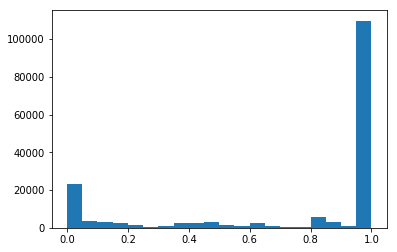

In [27]:
_ = plt.hist(1/(1+np.exp(-normed_protorole_appl[0])), bins=20)

In [39]:
normed_protorole = fit_ordinal_normalizer(protoroles_bulk['Response']-1,
                                          protoroles_bulk['unique_id'].cat.codes,
                                          protoroles_bulk['participant'],
                                          smoothing=1,
                                          iterations=15000)

0 	 -1132262.6 	 180.00002 	 7140890.5 	 0.36692747
1000 	 -192462.4 	 179.99997 	 896278.06 	 0.3894752
2000 	 -185289.11 	 180.0 	 887084.5 	 0.4026302
3000 	 -181238.03 	 180.0 	 883242.56 	 0.40885118
4000 	 -178880.84 	 180.0 	 881102.9 	 0.41212165
5000 	 -177213.66 	 179.99998 	 879547.1 	 0.4140022
6000 	 -175825.5 	 179.99998 	 878131.06 	 0.41541356
7000 	 -175643.84 	 180.00002 	 877903.8 	 0.4163215
8000 	 -175579.75 	 179.99998 	 877838.56 	 0.41663966
9000 	 -175542.72 	 180.00002 	 877801.2 	 0.41668952
10000 	 -175520.97 	 179.99998 	 877783.06 	 0.41661242
11000 	 -175498.84 	 180.0 	 877760.4 	 0.41675276
12000 	 -175485.1 	 180.0 	 877744.56 	 0.41676942
13000 	 -175507.86 	 180.00002 	 877769.6 	 0.4164435
14000 	 -175470.61 	 180.0 	 877728.6 	 0.41683838


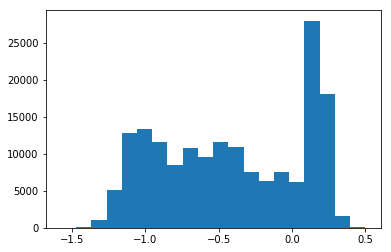

In [40]:
_ = plt.hist(normed_protorole[0], bins=20)

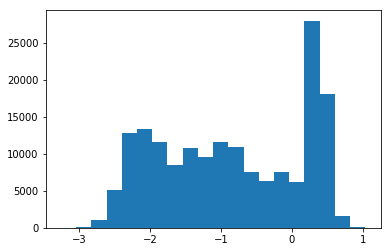

In [41]:
_ = plt.hist(normed_protorole[0]/normed_protorole[0].std(), bins=20)

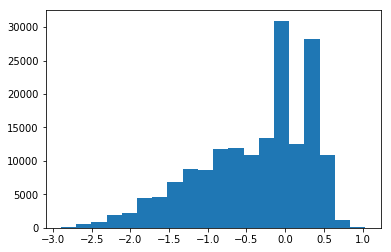

In [42]:
protorole_standardized = normed_protorole[0]/normed_protorole[0].std()
protorole_thresholded = np.maximum(np.minimum(protorole_standardized, 3), -3)
protorole_scaled = protorole_thresholded*1/(1+np.exp(-normed_protorole_appl[0]))

_ = plt.hist(protorole_scaled, bins=20)

In [43]:
protoroles_bulk['normed'] = protorole_scaled

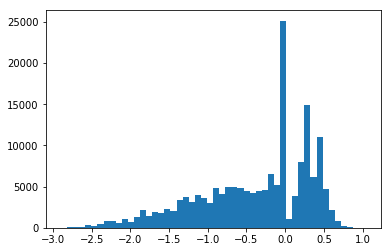

In [45]:
_ = plt.hist(protoroles_bulk['normed'], bins=50)

In [195]:
agg_by = ['Sentence.ID', 'Pred.Lemma', 'Pred.Token', 'Arg.Token', 'Arg.Tokens.Begin', 
          'Arg.Tokens.End', 'Arg.Phrase', 'Gram.Func', 'Property']

protoroles_bulk_agg = protoroles_bulk.pivot_table(index=agg_by, values=['normed']).reset_index()

protoroles_bulk_agg.head()

Sentence.ID Pred.Lemma  Pred.Token  Arg.Token  Arg.Tokens.Begin  \
0  en-ud-dev.conllu 1       come           3          0                 4   
1  en-ud-dev.conllu 1       come           3          0                 4   
2  en-ud-dev.conllu 1       come           3          0                 4   
3  en-ud-dev.conllu 1       come           3          0                 4   
4  en-ud-dev.conllu 1       come           3          0                 4   

   Arg.Tokens.End  Arg.Phrase Gram.Func                    Property    normed  
0               5  this story     nsubj                   awareness -0.000001  
1               5  this story     nsubj          change_of_location -0.413724  
2               5  this story     nsubj        change_of_possession -0.413724  
3               5  this story     nsubj             change_of_state -1.314338  
4               5  this story     nsubj  change_of_state_continuous -0.000003

In [197]:
protorole_out = defaultdict(dict)


for (sentid, plemma, ptokid, atokid, atokbeg, atokend, aphrase, gramfunc), df in protoroles_bulk_agg.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = [e for e in predpatt[fname][sentname].events if e.position==ptokid]
    
    if len(events)==0:
        print('ERROR: no corresponding event for predicate ', plemma, ptokid, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    elif len(events)>1:
        print('ERROR: too many events for predicate ', ptokid, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    
    ev = events[0]
    
    all_args = ev.arguments
    isarg = [aphrase==' '.join([t.text.lower() for t in a.tokens]) for a in all_args]
    
    if sum(isarg)!=1:
        isarg = [a.root.gov_rel==gramfunc for a in all_args]
        if sum(isarg)!=1:
            if aphrase in ['which', 'who', 'that']:
                isarg = [True] + [False]*(len(all_args)-1)
            else:
                argspans = [[t.position
                             for t in a.tokens]
                            for a in all_args]
                isarg = [((min(span)==atokbeg)&(max(span)==atokend))|\
                         all([atokbeg <= t <= atokend for t in span])
                         for span in argspans]
                
                if sum(isarg)!=1:
                    print('ERROR: no corresponding argument for argument', aphrase, atokid,
                          'of predicate', plemma, 'in', sentname)
                    print()
                    print(predpatt[fname][sentname].pprint())
                    print()
                    continue
    
    try:
        argrelpos = np.where(isarg)[0][0]
    except IndexError:
        print('ERROR: no match for', aphrase, atokid,
              'of predicate', plemma, 'in', sentname)
        print()
        print(predpatt[fname][sentname].pprint())
        print()
        continue
    
    arg = all_args[argrelpos]
    
    pair = sentname+'-semantics-pred-'+str(ev.position+1)+'_'+sentname+'-semantics-arg-'+str(arg.position+1)
    
    info = df[['Property', 'normed']].set_index('Property').normed.to_dict()
    
    protorole_out[sentname][pair] = {'protoroles-'+k: round(v,4) for k, v in info.items()}

ERROR: no corresponding argument for argument a taste fresh , locally sourced , fabulously prepared food 1 of predicate offer in ewt-train-10157

	?a offer ?b ?c in ?d
		?a: This French born , French trained chef and his creative partners
		?b: taste
		?c: a fresh , locally sourced , fabulously prepared food
		?d: the most unlikely of locations

ERROR: no corresponding event for predicate  crush 9 in ewt-train-12000

	?a runs ?b ?c
		?a: it
		?b: you
		?c: about 4 bucks
	?a deals ?b to ?c
		?a: it
		?b: crushing blows
		?c: hunger

ERROR: no corresponding argument for argument god 2 of predicate benefit in ewt-train-1397

	?a reported ?b
		?a: The Wall Street Journal
		?b: SOMETHING := a computer used by Zawahiri contains a June 1999 memo that " said the program should seek cover and talent in educational institutions , which it said were ' more beneficial to us and allow easy access to specialists , which will greatly benefit us in the first stage , God willing
	?a used by ?b
		?a: a 

In [198]:
with open('../data/protoroles/protoroles.json', 'w') as f:
    json.dump(protorole_out, f)

## Factuality

In [60]:
factuality = pd.read_csv('../data/factuality/it-happened_eng_ud1.2_07092017.tsv', sep='\t')

factuality.head()

Split  Annotator.ID  Display.Position           Sentence.ID  Pred.Token  \
0   dev             6                 1  en-ud-dev.conllu 780           8   
1   dev            14                 1  en-ud-dev.conllu 780           8   
2   dev             7                 1  en-ud-dev.conllu 802          11   
3   dev            14                 1  en-ud-dev.conllu 802          11   
4   dev             1                 1  en-ud-dev.conllu 807          47   

  Pred.Lemma  Is.Predicate  Is.Understandable Happened Confidence  Keep  
0    confess          True               True     true          4  True  
1    confess          True               True     true          4  True  
2     decide          True               True     true          4  True  
3     decide          True               True     true          4  True  
4        add         False               True       na         na  True

In [61]:
factuality['Happened'].value_counts()

true     34122
false    18764
na        1814
Name: Happened, dtype: int64

In [62]:
factuality['Confidence'].value_counts()

4     29309
2     12095
3      9497
1      1913
na     1814
0        72
Name: Confidence, dtype: int64

In [63]:
factuality_appl = factuality[(factuality['Happened']!='na')&(factuality['Confidence']!='na')]

In [64]:
factuality_appl['factual'] = factuality_appl['Happened'].map(lambda x: 1 if x=='true' else 0)

factuality_appl['factual'].value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1    34122
0    18764
Name: factual, dtype: int64

In [65]:
factuality_appl['conf'] = factuality_appl['Confidence'].astype(np.int32)

factuality_appl['conf'].value_counts()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4    29309
2    12095
3     9497
1     1913
0       72
Name: conf, dtype: int64

In [66]:
factuality_appl['unique_id'] = (factuality_appl['Sentence.ID'] + '-' +\
                                factuality_appl['Pred.Token'].astype(str)).astype('category')

factuality_appl['unique_id'].cat.categories

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Index(['en-ud-dev.conllu 1-4', 'en-ud-dev.conllu 100-2',
       'en-ud-dev.conllu 100-21', 'en-ud-dev.conllu 1000-1',
       'en-ud-dev.conllu 1000-10', 'en-ud-dev.conllu 1000-18',
       'en-ud-dev.conllu 1000-24', 'en-ud-dev.conllu 1000-31',
       'en-ud-dev.conllu 1000-6', 'en-ud-dev.conllu 1001-3',
       ...
       'en-ud-train.conllu 9995-34', 'en-ud-train.conllu 9995-51',
       'en-ud-train.conllu 9996-2', 'en-ud-train.conllu 9997-3',
       'en-ud-train.conllu 9998-14', 'en-ud-train.conllu 9998-20',
       'en-ud-train.conllu 9998-6', 'en-ud-train.conllu 9998-8',
       'en-ud-train.conllu 9999-13', 'en-ud-train.conllu 9999-19'],
      dtype='object', length=27403)

In [67]:
factuality_appl['participant'] = factuality_appl['Annotator.ID'].astype('category').cat.codes

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
# normed_factuality_conf = fit_ordinal_normalizer(factuality_appl['conf'],
#                                                 factuality_appl['unique_id'].cat.codes,
#                                                 factuality_appl['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_factuality_conf = factuality_appl.groupby('participant').conf.transform(ridit)

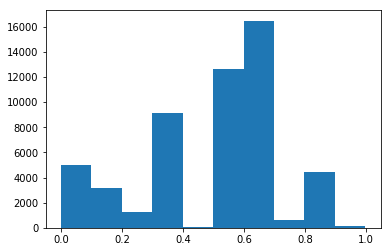

In [69]:
#_ = plt.hist(normed_factuality_conf[0]/normed_factuality_conf[0].mean())

_ = plt.hist(normed_factuality_conf)

In [70]:
normed_factuality_fact = fit_ordinal_normalizer(factuality_appl['factual'],
                                                factuality_appl['unique_id'].cat.codes,
                                                factuality_appl['participant'],
                                                weights=normed_factuality_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -18329.133 	 46.999996 	 56364.094 	 0.49999958
1000 	 -9588.864 	 46.999996 	 49893.01 	 0.6829647
2000 	 -9588.081 	 46.999992 	 49891.73 	 0.68305916
3000 	 -9580.84 	 47.0 	 49884.05 	 0.6831734
4000 	 -9577.023 	 47.000008 	 49880.96 	 0.68329555
5000 	 -9576.753 	 47.0 	 49880.75 	 0.683306
6000 	 -9577.777 	 47.0 	 49882.168 	 0.6834867
7000 	 -9576.888 	 46.999992 	 49880.82 	 0.68325907
8000 	 -9576.841 	 47.000008 	 49880.86 	 0.68329763
9000 	 -9576.823 	 46.99999 	 49880.93 	 0.68331146


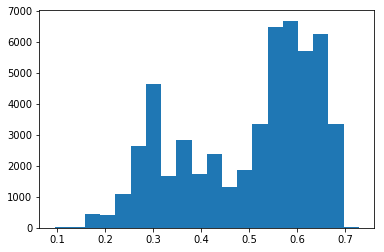

In [71]:
_ = plt.hist(1/(1+np.exp(-normed_factuality_fact[0])), bins=20)

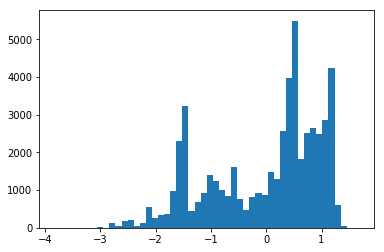

In [72]:
_ = plt.hist(normed_factuality_fact[0]/normed_factuality_fact[0].std(), bins=50)

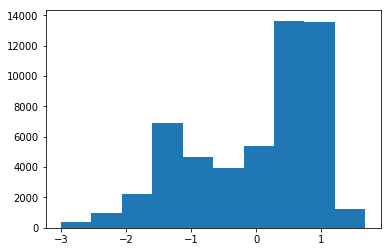

In [73]:
normed_factuality_standardized = normed_factuality_fact[0]/normed_factuality_fact[0].std()
normed_factuality_thresholded = np.minimum(np.maximum(normed_factuality_standardized, -3), 3)

_ = plt.hist(normed_factuality_thresholded)

In [74]:
factuality_appl['normed'] = normed_factuality_thresholded

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


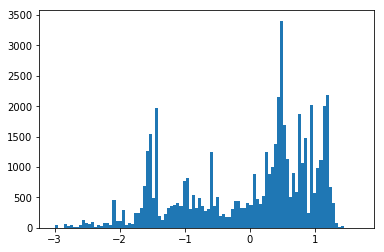

In [75]:
_ = plt.hist(factuality_appl['normed'], bins=100)

In [199]:
agg_by = ['Sentence.ID', 'Pred.Lemma', 'Pred.Token']

factuality_appl_agg = factuality_appl.pivot_table(index=agg_by, values='normed').reset_index()

factuality_appl_agg.head()

Sentence.ID Pred.Lemma  Pred.Token    normed
0     en-ud-dev.conllu 1       come           4  0.260967
1   en-ud-dev.conllu 100        cry           2  0.459939
2   en-ud-dev.conllu 100        get          21 -2.508357
3  en-ud-dev.conllu 1000   complete          31  0.767759
4  en-ud-dev.conllu 1000   continue          24  0.767758

In [200]:
factuality_out = defaultdict(dict)

subpredpred = 0
subpredarg = 0
nomatch = 0

for (sentid, plemma, ptokid), df in factuality_appl_agg.groupby(agg_by):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = predpatt[fname][sentname].events
    
    if (ptokid-1) in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid)
        factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0])}
        
    else:
        minsize = min([len([t.position for t in a.tokens])
                       for e in events
                       for a in e.arguments]+\
                      [len([t.position for t in e.tokens])
                       for e in events]+[1000000])
        
        inpred = [e.position for e in events
                  if (ptokid-1) in [t.position for t in e.tokens]
                  if len([t.position for t in e.tokens]) == minsize]
        
        inarg = [a.position 
                 for e in events
                 for a in e.arguments
                 if (ptokid-1) in [t.position for t in a.tokens] 
                 if len([t.position for t in a.tokens]) == minsize]
        
        assert not (inpred and inarg)
            
        if inpred:
            predid = sentname+'-semantics-subpred-'+str(ptokid)
            subpredpred += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0]),
                                                'subpredof': sentname+'-semantics-pred-'+str(inpred[0])}
        elif inarg:
            predid = sentname+'-semantics-subpred-'+str(ptokid)
            subpredarg += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0]),
                                                'subpredof': sentname+'-semantics-arg-'+str(inarg[0])}         
        else:
            predid = sentname+'-semantics-pred-'+str(ptokid)
            nomatch += 1
            factuality_out[sentname][predid] = {'factuality-factual': float(df['normed'].values[0])}
            print('ERROR: no matching predicate or argument for', plemma, predid, events)

ERROR: no matching predicate or argument for complete ewt-dev-1000-semantics-pred-31 [Predicate(Listing/0), Predicate(told/5), Predicate(determined/15), Predicate(provide/17), Predicate(continue/23)]
ERROR: no matching predicate or argument for rule ewt-dev-1000-semantics-pred-10 [Predicate(Listing/0), Predicate(told/5), Predicate(determined/15), Predicate(provide/17), Predicate(continue/23)]
ERROR: no matching predicate or argument for escalate ewt-dev-1011-semantics-pred-23 [Predicate(announced/6)]
ERROR: no matching predicate or argument for provoke ewt-dev-110-semantics-pred-35 [Predicate(situation/4), Predicate(evacuated/11), Predicate(hit/18), Predicate(predictable/29), Predicate(rained/37)]
ERROR: no matching predicate or argument for help ewt-dev-1124-semantics-pred-2 []
ERROR: no matching predicate or argument for help ewt-dev-1134-semantics-pred-2 []
ERROR: no matching predicate or argument for steal ewt-dev-1138-semantics-pred-3 [Predicate(google/0)]
ERROR: no matching predi

ERROR: no matching predicate or argument for base ewt-dev-47-semantics-pred-18 [Predicate(gave/1)]
ERROR: no matching predicate or argument for dial ewt-dev-47-semantics-pred-28 [Predicate(gave/1)]
ERROR: no matching predicate or argument for retire ewt-dev-488-semantics-pred-4 []
ERROR: no matching predicate or argument for work ewt-dev-488-semantics-pred-1 []
ERROR: no matching predicate or argument for attach ewt-dev-498-semantics-pred-3 [Predicate(See/1)]
ERROR: no matching predicate or argument for intend ewt-dev-501-semantics-pred-6 [Predicate(recipient/6), Predicate(notified/11), Predicate(received/15), Predicate(prohibited/34)]
ERROR: no matching predicate or argument for link ewt-dev-51-semantics-pred-9 [Predicate(cited/3), Predicate(shows/10), Predicate(intend/17), Predicate(use/19), Predicate(popular/28)]
ERROR: no matching predicate or argument for base ewt-dev-519-semantics-pred-37 [Predicate(thinker/4), Predicate(demand/8), Predicate(partner/18), Predicate(trust/22), Pred

ERROR: no matching predicate or argument for revise ewt-test-651-semantics-pred-4 [Predicate(Here/0)]
ERROR: no matching predicate or argument for accord ewt-test-67-semantics-pred-27 [Predicate(task/9), Predicate(keeping/11), Predicate(pledging/15), Predicate(need/23)]
ERROR: no matching predicate or argument for regard ewt-test-674-semantics-pred-8 [Predicate(wanted/2), Predicate(check/4), Predicate(discussed/12)]
ERROR: no matching predicate or argument for accord ewt-test-68-semantics-pred-16 [Predicate(given/4), Predicate(needs/13)]
ERROR: no matching predicate or argument for compare ewt-test-78-semantics-pred-24 [Predicate(invests/8), Predicate(means/16), Predicate(donating/17), Predicate(adds/19), Predicate(donating/25)]
ERROR: no matching predicate or argument for see ewt-test-787-semantics-pred-2 []
ERROR: no matching predicate or argument for establish ewt-test-793-semantics-pred-3 [Predicate(have/10), Predicate(reporting/12), Predicate(change/21)]
ERROR: no matching predica

ERROR: no matching predicate or argument for tow ewt-train-10751-semantics-pred-14 [Predicate(looking/3), Predicate(offer/9), Predicate(company/22)]
ERROR: no matching predicate or argument for base ewt-train-10756-semantics-pred-1 [Predicate(stated/9), Predicate(excellent/18)]
ERROR: no matching predicate or argument for fail ewt-train-1076-semantics-pred-11 [Predicate(process/12)]
ERROR: no matching predicate or argument for operate ewt-train-10761-semantics-pred-4 [Predicate(makes/4), Predicate(sure/5), Predicate(relaxed/9), Predicate(cooked/15)]
ERROR: no matching predicate or argument for own ewt-train-10761-semantics-pred-2 [Predicate(makes/4), Predicate(sure/5), Predicate(relaxed/9), Predicate(cooked/15)]
ERROR: no matching predicate or argument for threaten ewt-train-10804-semantics-pred-19 [Predicate(had/3), Predicate(wait/5), Predicate(system/12), Predicate(takes/14)]
ERROR: no matching predicate or argument for tell ewt-train-10836-semantics-pred-10 [Predicate(tried/1), Pred

ERROR: no matching predicate or argument for go ewt-train-11848-semantics-pred-15 [Predicate(have/17)]
ERROR: no matching predicate or argument for go ewt-train-11879-semantics-pred-10 []
ERROR: no matching predicate or argument for include ewt-train-11886-semantics-pred-18 [Predicate(based/5), Predicate(advertised/10)]
ERROR: no matching predicate or argument for size ewt-train-119-semantics-pred-5 [Predicate(Remember/0), Predicate(form/9)]
ERROR: no matching predicate or argument for fund ewt-train-1190-semantics-pred-20 [Predicate(weapon/9)]
ERROR: no matching predicate or argument for include ewt-train-1190-semantics-pred-30 [Predicate(weapon/9)]
ERROR: no matching predicate or argument for live ewt-train-11904-semantics-pred-3 [Predicate(regret/7)]
ERROR: no matching predicate or argument for require ewt-train-11909-semantics-pred-6 [Predicate(giving/3), Predicate(seeing/14), Predicate(sorry/22), Predicate(did/24)]
ERROR: no matching predicate or argument for stay ewt-train-11934-

ERROR: no matching predicate or argument for elect ewt-train-187-semantics-pred-15 [Predicate(dangerous/4), Predicate(condone/9), Predicate(said/18)]
ERROR: no matching predicate or argument for follow ewt-train-1871-semantics-pred-11 [Predicate(looking/3)]
ERROR: no matching predicate or argument for number ewt-train-1875-semantics-pred-5 [Predicate(want/1)]
ERROR: no matching predicate or argument for sign ewt-train-1875-semantics-pred-3 [Predicate(want/1)]
ERROR: no matching predicate or argument for elect ewt-train-188-semantics-pred-38 [Predicate(know/5), Predicate(who/6), Predicate(seems/13), Predicate(confused/16), Predicate(taking/22), Predicate(went/28), Predicate(suggest/31), Predicate(bring/61)]
ERROR: no matching predicate or argument for oppose ewt-train-195-semantics-pred-12 [Predicate(tell/3), Predicate(becoming/7), Predicate(unstable/9)]
ERROR: no matching predicate or argument for figure ewt-train-1951-semantics-pred-1 []
ERROR: no matching predicate or argument for li

ERROR: no matching predicate or argument for call ewt-train-337-semantics-pred-6 [Predicate(considered/10), Predicate(wanted/16), Predicate(fly/18)]
ERROR: no matching predicate or argument for go ewt-train-3373-semantics-pred-25 [Predicate(mean/2), Predicate(do/16), Predicate(make/20), Predicate(assume/29), Predicate(work/32)]
ERROR: no matching predicate or argument for go ewt-train-3396-semantics-pred-25 [Predicate(mean/2), Predicate(do/16), Predicate(make/20), Predicate(assume/29), Predicate(work/32)]
ERROR: no matching predicate or argument for revise ewt-train-3432-semantics-pred-4 [Predicate(Attached/0), Predicate(reflects/7)]
ERROR: no matching predicate or argument for redline ewt-train-3441-semantics-pred-6 [Predicate(included/3), Predicate(showing/7)]
ERROR: no matching predicate or argument for plan ewt-train-3450-semantics-pred-20 [Predicate(going/14), Predicate(propose/16)]
ERROR: no matching predicate or argument for depend ewt-train-3458-semantics-pred-32 [Predicate(tar

ERROR: no matching predicate or argument for use ewt-train-5198-semantics-pred-37 [Predicate(look/5), Predicate(see/11), Predicate(are/14), Predicate(spent/22), Predicate(ensure/30), Predicate(bill/32)]
ERROR: no matching predicate or argument for aggravate ewt-train-521-semantics-pred-22 [Predicate(booked/16), Predicate(walked/32), Predicate(said/42), Predicate(implicate/45), Predicate(occurred/55)]
ERROR: no matching predicate or argument for do ewt-train-5230-semantics-pred-17 [Predicate(guess/1), Predicate(like/8), Predicate(are/11), Predicate(have/18), Predicate(made/29)]
ERROR: no matching predicate or argument for release ewt-train-526-semantics-pred-3 [Predicate(showing/5), Predicate(complicit/7), Predicate(mentioned/14)]
ERROR: no matching predicate or argument for attach ewt-train-5276-semantics-pred-2 [Predicate(sent/5)]
ERROR: no matching predicate or argument for attach ewt-train-5277-semantics-pred-3 [Predicate(See/1)]
ERROR: no matching predicate or argument for revise e

ERROR: no matching predicate or argument for legalise ewt-train-7021-semantics-pred-14 [Predicate(given/10), Predicate(study/12)]
ERROR: no matching predicate or argument for change ewt-train-703-semantics-pred-10 [Predicate(clear/4), Predicate(reconsider/31), Predicate(giving/35), Predicate(living/41)]
ERROR: no matching predicate or argument for propose ewt-train-7038-semantics-pred-5 []
ERROR: no matching predicate or argument for accord ewt-train-7042-semantics-pred-22 [Predicate(made/9)]
ERROR: no matching predicate or argument for estimate ewt-train-7043-semantics-pred-4 [Predicate(took/9)]
ERROR: no matching predicate or argument for estimate ewt-train-7044-semantics-pred-5 [Predicate(projected/13)]
ERROR: no matching predicate or argument for accord ewt-train-7045-semantics-pred-15 []
ERROR: no matching predicate or argument for confiscate ewt-train-7047-semantics-pred-13 [Predicate(spent/7), Predicate(using/9), Predicate(build/16), Predicate(prevented/23), Predicate(starting/2

In [201]:
nomatch, subpredpred, subpredarg

(1385, 4, 33)

In [202]:
with open('../data/factuality/factuality.json', 'w') as f:
    json.dump(factuality_out, f)

## Genericity

### Predicate

In [81]:
genericity_pred = pd.read_csv('../data/genericity/pred_long_data.tsv', sep='\t')

genericity_pred.head()

Split  Annotator.ID                Sentence.ID  Pred.Token Ann.Token  \
0  train           247  en-ud-train.conllu sent_1           7         7   
1  train           247  en-ud-train.conllu sent_2          10        10   
2  train           247  en-ud-train.conllu sent_2          16        16   
3  train           247  en-ud-train.conllu sent_3           5         5   
4  train           247  en-ud-train.conllu sent_3           9         9   

   Pred.Span   Arg.Token                                           Arg.Span  \
0       7,16     6,12,18  5,6;8,9,10,11,12,13,14,15;17,18,19,20,21,22,23...   
1  8,9,10,13  3,11,12,14                         2,3,4,5,6,7;11;12;14,15,16   
2         16          14                                                 14   
3          5         4,9                     3,4;7,8,9,10,11,12,13,14,15,16   
4     8,9,10        7,13                                7;11,12,13,14,15,16   

   Pred.Word Pred.Lemma  Is.Particular  Part.Confidence  Is.Dynamic  \
0     killed       kill           True                4        True   
1    causing      cause          False                1        True   
2       come       come          False                0        True   
3  announced   announce           True                4       False   
4     busted       bust           True                4       False   

   Dyn.Confidence  Is.Hypothetical  Hyp.Confidence  
0               4            False               4  
1               2             True               2  
2               1             True               2  
3               4            False               4  
4               4            False               4

In [82]:
genericity_pred_part = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Particular', 'Part.Confidence']]
genericity_pred_part['property'] = 'particular'
genericity_pred_part = genericity_pred_part.rename(columns={'Is.Particular': 'response', 
                                                          'Part.Confidence': 'confidence'})

genericity_pred_dyn = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Dynamic', 'Dyn.Confidence']]
genericity_pred_dyn['property'] = 'dynamic'
genericity_pred_dyn = genericity_pred_dyn.rename(columns={'Is.Dynamic': 'response', 
                                                          'Dyn.Confidence': 'confidence'})

genericity_pred_hyp = genericity_pred[list(genericity_pred.columns[:-6].values)+['Is.Hypothetical', 'Hyp.Confidence']]
genericity_pred_hyp['property'] = 'hypothetical'
genericity_pred_hyp = genericity_pred_hyp.rename(columns={'Is.Hypothetical': 'response',
                                                        'Hyp.Confidence': 'confidence'})

genericity_pred = pd.concat([genericity_pred_part, genericity_pred_dyn, genericity_pred_hyp])

genericity_pred.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Split  Annotator.ID                Sentence.ID  Pred.Token Ann.Token  \
0  train           247  en-ud-train.conllu sent_1           7         7   
1  train           247  en-ud-train.conllu sent_2          10        10   
2  train           247  en-ud-train.conllu sent_2          16        16   
3  train           247  en-ud-train.conllu sent_3           5         5   
4  train           247  en-ud-train.conllu sent_3           9         9   

   Pred.Span   Arg.Token                                           Arg.Span  \
0       7,16     6,12,18  5,6;8,9,10,11,12,13,14,15;17,18,19,20,21,22,23...   
1  8,9,10,13  3,11,12,14                         2,3,4,5,6,7;11;12;14,15,16   
2         16          14                                                 14   
3          5         4,9                     3,4;7,8,9,10,11,12,13,14,15,16   
4     8,9,10        7,13                                7;11,12,13,14,15,16   

   Pred.Word Pred.Lemma  response  confidence    property  
0     killed       kill      True           4  particular  
1    causing      cause     False           1  particular  
2       come       come     False           0  particular  
3  announced   announce      True           4  particular  
4     busted       bust      True           4  particular

In [83]:
genericity_pred['response'] = genericity_pred.response.map(lambda x: 1 if x else 0)

genericity_pred['response'].value_counts()

1    70074
0    67626
Name: response, dtype: int64

In [84]:
genericity_pred['response'].isnull().sum()

0

In [85]:
genericity_pred['confidence'].value_counts()

4    90456
2    22585
3    16055
1     5063
0     3541
Name: confidence, dtype: int64

In [86]:
genericity_pred['confidence'].isnull().sum()

0

In [87]:
genericity_pred['unique_id'] = (genericity_pred['Sentence.ID'] + '-' +\
                                genericity_pred['Pred.Token'].astype(str) + '-' +\
                                genericity_pred['property']).astype('category')

genericity_pred['unique_id'].cat.categories

Index(['en-ud-dev.conllu sent_1-4-dynamic',
       'en-ud-dev.conllu sent_1-4-hypothetical',
       'en-ud-dev.conllu sent_1-4-particular',
       'en-ud-dev.conllu sent_100-10-dynamic',
       'en-ud-dev.conllu sent_100-10-hypothetical',
       'en-ud-dev.conllu sent_100-10-particular',
       'en-ud-dev.conllu sent_100-11-dynamic',
       'en-ud-dev.conllu sent_100-11-hypothetical',
       'en-ud-dev.conllu sent_100-11-particular',
       'en-ud-dev.conllu sent_100-2-dynamic',
       ...
       'en-ud-train.conllu sent_9998-6-particular',
       'en-ud-train.conllu sent_9998-8-dynamic',
       'en-ud-train.conllu sent_9998-8-hypothetical',
       'en-ud-train.conllu sent_9998-8-particular',
       'en-ud-train.conllu sent_9999-13-dynamic',
       'en-ud-train.conllu sent_9999-13-hypothetical',
       'en-ud-train.conllu sent_9999-13-particular',
       'en-ud-train.conllu sent_9999-5-dynamic',
       'en-ud-train.conllu sent_9999-5-hypothetical',
       'en-ud-train.conllu sent_9999-

In [88]:
genericity_pred['participant'] = genericity_pred['Annotator.ID'].astype('category').cat.codes

genericity_pred['participant'].value_counts()

436    4830
190    2580
310    2160
302    2070
160    1680
254    1560
178    1560
390    1530
348    1530
261    1500
296    1500
279    1500
380    1500
339    1500
350    1500
53     1500
32     1500
399    1497
417    1470
61     1470
280    1470
219    1467
200    1440
352    1434
360    1410
2      1380
210    1350
9      1230
410    1170
426    1140
       ... 
24       30
407      30
430      30
86       30
214      30
406      30
278      30
283      30
156      30
162      30
287      30
34       30
325      30
70       30
326      30
33       30
327      30
201      30
330      30
159      30
284      30
31       30
331      30
76       30
30       30
205      30
333      30
157      30
334      30
383      30
Name: participant, Length: 437, dtype: int64

In [89]:
# normed_genericity_pred_conf = fit_ordinal_normalizer(genericity_pred['confidence'],
#                                                 genericity_pred['unique_id'].cat.codes,
#                                                 genericity_pred['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_genericity_pred_conf = genericity_pred.groupby('participant').confidence.transform(ridit)

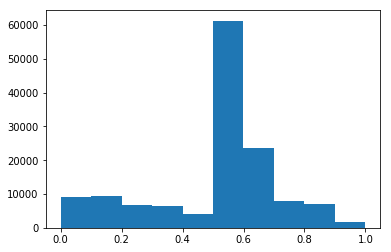

In [90]:
#_ = plt.hist(normed_genericity_pred_conf[0]/normed_genericity_pred_conf[0].mean())
_ = plt.hist(normed_genericity_pred_conf)

In [91]:
normed_genericity_pred_resp = fit_ordinal_normalizer(genericity_pred['response'],
                                                genericity_pred['unique_id'].cat.codes,
                                                genericity_pred['participant'],
                                                weights=normed_genericity_pred_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -47723.56 	 437.00003 	 185040.98 	 0.5
1000 	 -32495.826 	 437.00003 	 174910.58 	 0.62155914
2000 	 -32495.727 	 437.0 	 174910.12 	 0.6215658
3000 	 -32495.7 	 437.00006 	 174910.67 	 0.62156045
4000 	 -32495.766 	 437.0 	 174910.44 	 0.6215599
5000 	 -32495.824 	 436.99997 	 174910.47 	 0.6215628
6000 	 -32495.762 	 436.99997 	 174910.19 	 0.621559
7000 	 -32495.695 	 436.99997 	 174910.34 	 0.62156236
8000 	 -32495.793 	 437.00003 	 174911.31 	 0.62155974
9000 	 -32495.648 	 437.00003 	 174910.72 	 0.6215604


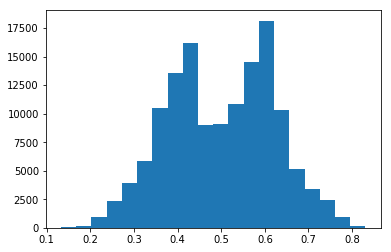

In [92]:
_ = plt.hist(1/(1+np.exp(-normed_genericity_pred_resp[0])), bins=20)

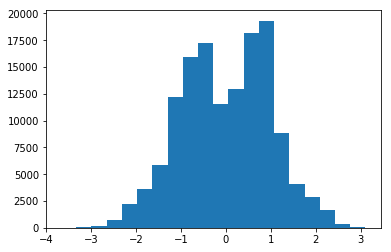

In [93]:
_ = plt.hist(normed_genericity_pred_resp[0]/normed_genericity_pred_resp[0].std(), bins=20)

In [94]:
genericity_pred['normed'] = normed_genericity_pred_resp[0]/normed_genericity_pred_resp[0].std()

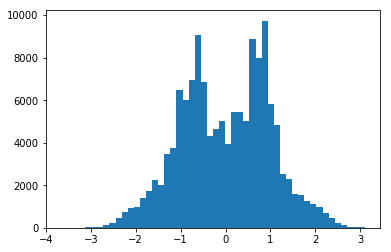

In [95]:
_ = plt.hist(genericity_pred['normed'], bins=50)

In [190]:
agg_by = ['Sentence.ID', 'Pred.Token', 'property']

genericity_pred_agg = genericity_pred.pivot_table(index=agg_by, values='normed').reset_index()

genericity_pred_agg.head()

Sentence.ID  Pred.Token      property    normed
0    en-ud-dev.conllu sent_1           4       dynamic -0.233812
1    en-ud-dev.conllu sent_1           4  hypothetical -0.317410
2    en-ud-dev.conllu sent_1           4    particular  1.918698
3  en-ud-dev.conllu sent_100           2       dynamic  0.888125
4  en-ud-dev.conllu sent_100           2  hypothetical -1.031769

In [191]:
genericity_out = defaultdict(dict)

for (sentid, ptokid), df in genericity_pred_agg.groupby(agg_by[:-1]):
    fname, position = sentid.replace(' sent', '').split('_')
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)

    if (ptokid-1) in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid)
        info = df[['property', 'normed']].set_index('property').normed.to_dict()
        genericity_out[sentname][predid] = {'genericity-pred-'+k: round(v,4) for k, v in info.items()}
    else:
        print('ERROR: no matching predicate for', predid)

### Argument

In [99]:
genericity_arg = pd.read_csv('../data/genericity/arg_long_data.tsv', sep='\t')

genericity_arg.head()

Split  Annotator.ID                   Sentence.ID  Arg.Token  \
0  train           180  en-ud-train.conllu sent_4522         32   
1  train           180  en-ud-train.conllu sent_4522         41   
2  train           180  en-ud-train.conllu sent_4522         46   
3  train           180  en-ud-train.conllu sent_4522         49   
4  train           180  en-ud-train.conllu sent_4523          2   

               Arg.Span  Pred.Token Pred.Span Arg.Word Arg.Lemma  \
0              30,31,32          29     29,33      one       one   
1  35,36,37,38,39,40,41          42        42       SE        SE   
2                 45,46          43        43      bit       bit   
3                    49          50        50      you       you   
4                     2           3     1,3,5      you       you   

   Is.Particular  Part.Confidence  Is.Kind  Kind.Confidence  Is.Abstract  \
0           True                4     True                4         True   
1           True                4    False                4        False   
2          False                4    False                4        False   
3           True                4    False                4        False   
4           True                4    False                4        False   

   Abs.Confidence  
0               4  
1               4  
2               4  
3               4  
4               4

In [100]:
genericity_arg_part = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Particular', 'Part.Confidence']]
genericity_arg_part['property'] = 'particular'
genericity_arg_part = genericity_arg_part.rename(columns={'Is.Particular': 'response', 
                                                          'Part.Confidence': 'confidence'})

genericity_arg_kind = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Kind', 'Kind.Confidence']]
genericity_arg_kind['property'] = 'kind'
genericity_arg_kind = genericity_arg_kind.rename(columns={'Is.Kind': 'response', 
                                                          'Kind.Confidence': 'confidence'})

genericity_arg_abs = genericity_arg[list(genericity_arg.columns[:-6].values)+['Is.Abstract', 'Abs.Confidence']]
genericity_arg_abs['property'] = 'abstract'
genericity_arg_abs = genericity_arg_abs.rename(columns={'Is.Abstract': 'response',
                                                        'Abs.Confidence': 'confidence'})

genericity_arg = pd.concat([genericity_arg_part, genericity_arg_kind, genericity_arg_abs])

genericity_arg.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Split  Annotator.ID                   Sentence.ID  Arg.Token  \
0  train           180  en-ud-train.conllu sent_4522         32   
1  train           180  en-ud-train.conllu sent_4522         41   
2  train           180  en-ud-train.conllu sent_4522         46   
3  train           180  en-ud-train.conllu sent_4522         49   
4  train           180  en-ud-train.conllu sent_4523          2   

               Arg.Span  Pred.Token Pred.Span Arg.Word Arg.Lemma  response  \
0              30,31,32          29     29,33      one       one      True   
1  35,36,37,38,39,40,41          42        42       SE        SE      True   
2                 45,46          43        43      bit       bit     False   
3                    49          50        50      you       you      True   
4                     2           3     1,3,5      you       you      True   

   confidence    property  
0           4  particular  
1           4  particular  
2           4  particular  
3           4  particular  
4           4  particular

In [101]:
genericity_arg['response'] = genericity_arg.response.map(lambda x: 1 if x else 0)

genericity_arg['response'].value_counts()

0    90031
1    64073
Name: response, dtype: int64

In [102]:
genericity_arg['response'].isnull().sum()

0

In [103]:
genericity_arg['confidence'].value_counts()

4    119794
2     16622
3     11398
0      3367
1      2923
Name: confidence, dtype: int64

In [104]:
genericity_arg['confidence'].isnull().sum()

0

In [105]:
genericity_arg['unique_id'] = (genericity_arg['Sentence.ID'] + '-' +\
                                genericity_arg['Arg.Token'].astype(str) + '-' +\
                                genericity_arg['property']).astype('category')

genericity_arg['unique_id'].cat.categories

Index(['en-ud-dev.conllu sent_1-3-abstract', 'en-ud-dev.conllu sent_1-3-kind',
       'en-ud-dev.conllu sent_1-3-particular',
       'en-ud-dev.conllu sent_1-6-abstract', 'en-ud-dev.conllu sent_1-6-kind',
       'en-ud-dev.conllu sent_1-6-particular',
       'en-ud-dev.conllu sent_100-1-abstract',
       'en-ud-dev.conllu sent_100-1-kind',
       'en-ud-dev.conllu sent_100-1-particular',
       'en-ud-dev.conllu sent_100-18-abstract',
       ...
       'en-ud-train.conllu sent_9999-12-particular',
       'en-ud-train.conllu sent_9999-15-abstract',
       'en-ud-train.conllu sent_9999-15-kind',
       'en-ud-train.conllu sent_9999-15-particular',
       'en-ud-train.conllu sent_9999-20-abstract',
       'en-ud-train.conllu sent_9999-20-kind',
       'en-ud-train.conllu sent_9999-20-particular',
       'en-ud-train.conllu sent_9999-6-abstract',
       'en-ud-train.conllu sent_9999-6-kind',
       'en-ud-train.conllu sent_9999-6-particular'],
      dtype='object', length=111438)

In [106]:
genericity_arg['participant'] = genericity_arg['Annotator.ID'].astype('category').cat.codes

genericity_arg['participant'].value_counts()

458    2490
209    2070
413    1917
142    1620
11     1590
469    1530
412    1530
379    1530
419    1500
425    1500
164    1500
461    1500
51     1500
427    1500
37     1500
166    1500
249    1500
262    1500
5      1500
128    1500
325    1500
231    1500
154    1500
199    1470
316    1440
293    1290
446    1260
449    1230
354    1200
474    1140
       ... 
28       30
411      30
218      30
345      30
300      30
165      30
172      30
44       30
83       30
467      30
43       30
212      30
298      30
170      30
213      30
297      30
169      30
41       30
424      30
214      30
87       30
215      30
39       30
422      30
294      30
344      30
472      30
421      30
217      30
113       6
Name: participant, Length: 481, dtype: int64

In [107]:
# normed_genericity_arg_conf = fit_ordinal_normalizer(genericity_arg['confidence'],
#                                                 genericity_arg['unique_id'].cat.codes,
#                                                 genericity_arg['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_genericity_arg_conf = genericity_arg.groupby('participant').confidence.transform(ridit)

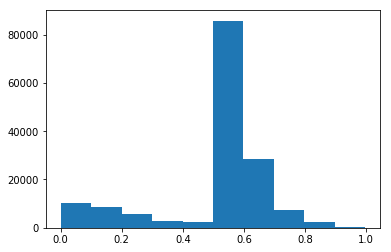

In [108]:
#_ = plt.hist(normed_genericity_arg_conf[0]/normed_genericity_arg_conf[0].mean())
_ = plt.hist(normed_genericity_arg_conf)

In [109]:
normed_genericity_arg_resp = fit_ordinal_normalizer(genericity_arg['response'],
                                                genericity_arg['unique_id'].cat.codes,
                                                genericity_arg['participant'],
                                                weights=normed_genericity_arg_conf.astype(np.float32),
                                                smoothing=1,
                                                iterations=10000)

0 	 -53408.875 	 481.0 	 208379.03 	 0.5
1000 	 -35392.89 	 481.00003 	 196415.72 	 0.63072073
2000 	 -35388.35 	 481.00006 	 196413.12 	 0.63086843
3000 	 -35388.33 	 481.0 	 196413.17 	 0.63087344
4000 	 -35388.28 	 481.0 	 196412.84 	 0.63086957
5000 	 -35388.395 	 481.00006 	 196412.11 	 0.63083625
6000 	 -35388.258 	 480.99994 	 196412.88 	 0.630894
7000 	 -35388.2 	 480.99994 	 196411.98 	 0.6308544
8000 	 -35388.414 	 480.99997 	 196412.56 	 0.6307972
9000 	 -35388.39 	 480.99988 	 196412.83 	 0.6308612


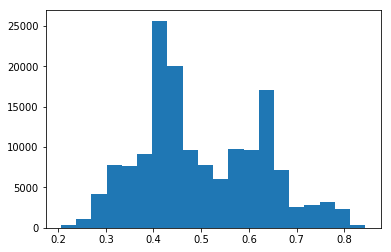

In [110]:
_ = plt.hist(1/(1+np.exp(-normed_genericity_arg_resp[0])), bins=20)

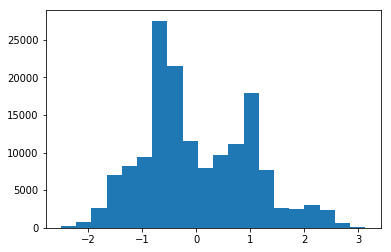

In [111]:
_ = plt.hist(normed_genericity_arg_resp[0]/normed_genericity_arg_resp[0].std(), bins=20)

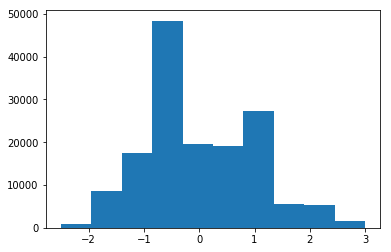

In [112]:
normed_genericity_arg_resp_standardized = normed_genericity_arg_resp[0]/normed_genericity_arg_resp[0].std()
normed_genericity_arg_resp_thresholded = np.maximum(np.minimum(normed_genericity_arg_resp_standardized, 3), -3)

_ = plt.hist(normed_genericity_arg_resp_thresholded)

In [113]:
genericity_arg['normed'] = normed_genericity_arg_resp_thresholded

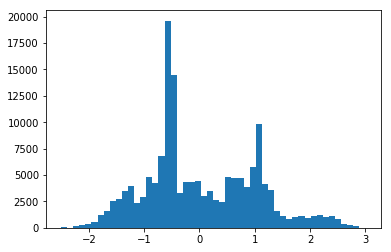

In [114]:
_ = plt.hist(genericity_arg['normed'], bins=50)

In [192]:
agg_by = ['Sentence.ID', 'Arg.Token', 'property']

genericity_arg_agg = genericity_arg.pivot_table(index=agg_by, values='normed').reset_index()

genericity_arg_agg.head()

Sentence.ID  Arg.Token    property    normed
0  en-ud-dev.conllu sent_1          3    abstract -1.685449
1  en-ud-dev.conllu sent_1          3        kind -1.685450
2  en-ud-dev.conllu sent_1          3  particular  2.514510
3  en-ud-dev.conllu sent_1          6    abstract -1.395024
4  en-ud-dev.conllu sent_1          6        kind -0.151594

We handle copular predicates with nominal complements such as *is a small country* in *Iguazu is a small country* (`ewt-dev-1030`) by annotating *is a small country* as a predicate and *a small country* as an argument.

In [193]:
for (sentid, atokid), df in genericity_arg_agg.groupby(agg_by[:-1]):
    fname, position = sentid.replace(' sent', '').split('_')
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    possible_subarg = (atokid-1) not in [a.position
                                         for e in predpatt[fname][sentname].events
                                         for a in e.arguments]
    
    if possible_subarg:
        subargofpred = (atokid-1) in [e.position for e in predpatt[fname][sentname].events]
        
        if subargofpred:
            argid = sentname+'-semantics-subarg-'+str(atokid)
            info = df[['property', 'normed']].set_index('property').normed.to_dict()
            genericity_out[sentname][argid] = {'genericity-arg-'+k: round(v,4) for k, v in info.items()}
            genericity_out[sentname][argid]['subargof'] = sentname+'-semantics-pred-'+str(atokid)
        else:
            print('ERROR: no matching argument or predicate for', argid)
    
    else:
        argid = sentname+'-semantics-arg-'+str(atokid)
        info = df[['property', 'normed']].set_index('property').normed.to_dict()
        genericity_out[sentname][argid] = {'genericity-arg-'+k: round(v,4) for k, v in info.items()}

In [194]:
with open('../data/genericity/genericity.json', 'w') as f:
    json.dump(genericity_out, f)

## Time

In [119]:
time = pd.read_csv('../data/time/time_eng_ud_v1.2_2015_10_30.tsv', sep='\t')

time.head()

Split  Annotator.ID             Sentence1.ID Pred1.Span  Pred1.Token  \
0  train           209   en-ud-train.conllu 418         17           17   
1  train           209  en-ud-train.conllu 9490         51           51   
2  train           209  en-ud-train.conllu 7143          8            8   
3  train           209  en-ud-train.conllu 7786         17           17   
4  train           209  en-ud-train.conllu 5729          4            4   

                    Event1.ID             Sentence2.ID            Pred2.Span  \
0   en-ud-train.conllu 418_17   en-ud-train.conllu 418                 18_19   
1  en-ud-train.conllu 9490_51  en-ud-train.conllu 9490                    53   
2   en-ud-train.conllu 7143_8  en-ud-train.conllu 7144  11_12_13_14_15_18_19   
3  en-ud-train.conllu 7786_17  en-ud-train.conllu 7787           4_5_6_7_8_9   
4   en-ud-train.conllu 5729_4  en-ud-train.conllu 5729                    36   

   Pred2.Token                   Event2.ID     ...      Pred1.Duration  \
0           19   en-ud-train.conllu 418_19     ...                   2   
1           53  en-ud-train.conllu 9490_53     ...                   6   
2           14  en-ud-train.conllu 7144_14     ...                   7   
3            9   en-ud-train.conllu 7787_9     ...                   2   
4           36  en-ud-train.conllu 5729_36     ...                   2   

  Pred2.Duration Pred1.Beg Pred1.End  Pred2.Beg  Pred2.End  \
0              0        35        41         64         65   
1              6         0        65          0         65   
2              7         0        81          0         81   
3             10        35        44          0        100   
4              7        36        42          0         26   

   Pred1.Duration.Confidence  Pred2.Duration.Confidence  Relation.Confidence  \
0                        4.0                        4.0                  4.0   
1                        4.0                        4.0                  4.0   
2                        4.0                        4.0                  4.0   
3                        4.0                        4.0                  4.0   
4                        4.0                        4.0                  4.0   

   Document.ID  
0           10  
1          189  
2           83  
3          126  
4           65  

[5 rows x 24 columns]

### Duration

In [120]:
shared_head = []

time_dur1 = time[['Annotator.ID', 'Sentence1.ID', 'Pred1.Token', 'Pred1.Duration', 'Pred1.Duration.Confidence']]
time_dur2 = time[['Annotator.ID', 'Sentence2.ID', 'Pred2.Token', 'Pred2.Duration', 'Pred2.Duration.Confidence']]

time_dur = pd.concat([time_dur1.rename(columns=lambda x: x.replace('1', '')), 
                      time_dur2.rename(columns=lambda x: x.replace('2', ''))])

time_dur.head()

Annotator.ID              Sentence.ID  Pred.Token  Pred.Duration  \
0           209   en-ud-train.conllu 418          17              2   
1           209  en-ud-train.conllu 9490          51              6   
2           209  en-ud-train.conllu 7143           8              7   
3           209  en-ud-train.conllu 7786          17              2   
4           209  en-ud-train.conllu 5729           4              2   

   Pred.Duration.Confidence  
0                       4.0  
1                       4.0  
2                       4.0  
3                       4.0  
4                       4.0

In [121]:
time_dur['unique_id'] = (time_dur['Sentence.ID'] + '-' +\
                         time_dur['Pred.Token'].astype(str)).astype('category')

time_dur['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-3', 'en-ud-dev.conllu 100-1',
       'en-ud-dev.conllu 100-10', 'en-ud-dev.conllu 100-20',
       'en-ud-dev.conllu 100-9', 'en-ud-dev.conllu 1000-0',
       'en-ud-dev.conllu 1000-15', 'en-ud-dev.conllu 1000-17',
       'en-ud-dev.conllu 1000-23', 'en-ud-dev.conllu 1000-5',
       ...
       'en-ud-train.conllu 9995-25', 'en-ud-train.conllu 9995-33',
       'en-ud-train.conllu 9995-50', 'en-ud-train.conllu 9997-2',
       'en-ud-train.conllu 9998-13', 'en-ud-train.conllu 9998-19',
       'en-ud-train.conllu 9998-5', 'en-ud-train.conllu 9998-7',
       'en-ud-train.conllu 9999-12', 'en-ud-train.conllu 9999-4'],
      dtype='object', length=32302)

In [122]:
time_dur['participant'] = time_dur['Annotator.ID'].astype('category').cat.codes

time_dur['participant'].value_counts()

619    23672
310    18536
71      9570
211     6070
63      5630
91      4310
713     3720
269     3512
653     3380
96      3110
169     3100
427     3080
107     3040
414     3000
508     2620
448     2610
433     2100
333     2010
5       1800
209     1660
108     1570
548     1410
575     1350
742     1310
361     1280
591     1270
642     1190
549     1120
186      970
722      950
       ...  
337       10
327       10
582       10
190       10
450       10
446       10
574       10
702       10
319       10
511       10
703       10
192       10
576       10
704       10
705       10
66        10
578       10
454       10
706       10
195       10
323       10
579       10
707       10
196       10
324       10
580       10
197       10
581       10
70        10
0         10
Name: participant, Length: 765, dtype: int64

In [123]:
# normed_time_dur_conf = fit_ordinal_normalizer(time_dur['Pred.Duration.Confidence'],
#                                                 time_dur['unique_id'].cat.codes,
#                                                 time_dur['participant'],
#                                                 center=False,
#                                                 iterations=15000)

normed_time_dur_conf = time_dur.groupby('participant')['Pred.Duration.Confidence'].transform(ridit)

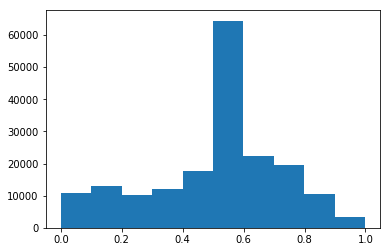

In [124]:
_ = plt.hist(normed_time_dur_conf)

In [125]:
normed_time_dur_resp = fit_multinomial_normalizer(time_dur['Pred.Duration'].values,
                                                  time_dur['unique_id'].cat.codes,
                                                  time_dur['participant'],
                                                  weights=normed_time_dur_conf.astype(np.float32),
                                                  #smoothing=0.1,
                                                  iterations=10000)

0 	 220407.45 	 8415.001 	 228822.45
1000 	 67088.07 	 8415.002 	 75503.07
2000 	 67050.734 	 8415.003 	 75465.734
3000 	 67042.08 	 8414.998 	 75457.08
4000 	 67039.53 	 8415.0 	 75454.53
5000 	 67037.92 	 8414.998 	 75452.92
6000 	 67038.61 	 8415.001 	 75453.61
7000 	 67036.34 	 8415.001 	 75451.34
8000 	 67037.555 	 8414.999 	 75452.555
9000 	 67035.84 	 8415.0 	 75450.84


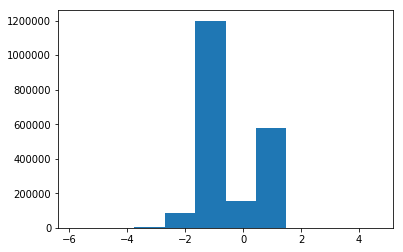

In [126]:
_ = plt.hist(normed_time_dur_resp[0].flatten()/normed_time_dur_resp[0].std())

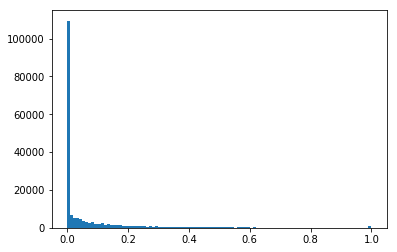

In [127]:
from scipy.special import softmax

_ = plt.hist(softmax(normed_time_dur_resp[0], axis=1)[:,6], bins=100)

In [128]:
normed_time_dur_resp_df = pd.DataFrame(normed_time_dur_resp[0]/normed_time_dur_resp[0].std(), 
                                       index=time_dur.index, 
                                       columns=['instant', 'seconds', 'minutes', 'hours', 
                                                'days', 'weeks', 'months', 'years', 'decades',
                                               'centuries', 'forever'])

normed_time_dur_resp_df.head()

instant   seconds   minutes     hours      days     weeks    months  \
0 -0.998456 -1.156960  1.282981 -1.174874 -1.290424 -1.401097 -1.388363   
1 -1.340641 -1.397740 -1.201590  0.733162 -1.472431 -1.589068  0.482189   
2 -1.706608 -0.984955 -0.964211 -1.186779 -1.218890 -1.377153  0.787288   
3 -2.029016 -1.312027  1.149175  0.826095  0.609234 -1.426539 -1.363513   
4 -0.934813  0.799796  1.117783 -1.116211  0.834749 -1.394636 -1.325539   

      years   decades  centuries   forever  
0 -1.292479 -1.421719  -1.164588 -1.089114  
1  0.205754  0.655462   0.878094  0.773367  
2  1.011106  0.640547  -1.067747 -0.965066  
3 -1.204855 -1.330294  -1.117991 -1.171808  
4 -1.208012 -1.419806  -1.298749 -1.154036

In [129]:
time_dur_normed = pd.concat([time_dur, normed_time_dur_resp_df], axis=1)

time_dur_normed.head()

Annotator.ID              Sentence.ID  Pred.Token  Pred.Duration  \
0           209   en-ud-train.conllu 418          17              2   
1           209  en-ud-train.conllu 9490          51              6   
2           209  en-ud-train.conllu 7143           8              7   
3           209  en-ud-train.conllu 7786          17              2   
4           209  en-ud-train.conllu 5729           4              2   

   Pred.Duration.Confidence                   unique_id  participant  \
0                       4.0   en-ud-train.conllu 418-17          209   
1                       4.0  en-ud-train.conllu 9490-51          209   
2                       4.0   en-ud-train.conllu 7143-8          209   
3                       4.0  en-ud-train.conllu 7786-17          209   
4                       4.0   en-ud-train.conllu 5729-4          209   

    instant   seconds   minutes     hours      days     weeks    months  \
0 -0.998456 -1.156960  1.282981 -1.174874 -1.290424 -1.401097 -1.388363   
1 -1.340641 -1.397740 -1.201590  0.733162 -1.472431 -1.589068  0.482189   
2 -1.706608 -0.984955 -0.964211 -1.186779 -1.218890 -1.377153  0.787288   
3 -2.029016 -1.312027  1.149175  0.826095  0.609234 -1.426539 -1.363513   
4 -0.934813  0.799796  1.117783 -1.116211  0.834749 -1.394636 -1.325539   

      years   decades  centuries   forever  
0 -1.292479 -1.421719  -1.164588 -1.089114  
1  0.205754  0.655462   0.878094  0.773367  
2  1.011106  0.640547  -1.067747 -0.965066  
3 -1.204855 -1.330294  -1.117991 -1.171808  
4 -1.208012 -1.419806  -1.298749 -1.154036

In [130]:
time_dur_normed_melted = pd.melt(time_dur_normed, id_vars=time_dur.columns, var_name='duration', value_name='normed')

time_dur_normed_melted.head()

Annotator.ID              Sentence.ID  Pred.Token  Pred.Duration  \
0           209   en-ud-train.conllu 418          17              2   
1           209  en-ud-train.conllu 9490          51              6   
2           209  en-ud-train.conllu 7143           8              7   
3           209  en-ud-train.conllu 7786          17              2   
4           209  en-ud-train.conllu 5729           4              2   

   Pred.Duration.Confidence                   unique_id  participant duration  \
0                       4.0   en-ud-train.conllu 418-17          209  instant   
1                       4.0  en-ud-train.conllu 9490-51          209  instant   
2                       4.0   en-ud-train.conllu 7143-8          209  instant   
3                       4.0  en-ud-train.conllu 7786-17          209  instant   
4                       4.0   en-ud-train.conllu 5729-4          209  instant   

     normed  
0 -0.998456  
1 -1.340641  
2 -1.706608  
3 -2.029016  
4 -0.934813

In [180]:
agg_by = ['Sentence.ID', 'Pred.Token', 'duration']

time_dur_agg = time_dur_normed_melted.pivot_table(index=agg_by, values='normed').reset_index()

time_dur_agg.head()

Sentence.ID  Pred.Token   duration    normed
0  en-ud-dev.conllu 1           3  centuries -1.169419
1  en-ud-dev.conllu 1           3       days  0.855421
2  en-ud-dev.conllu 1           3    decades -1.114000
3  en-ud-dev.conllu 1           3    forever -1.462356
4  en-ud-dev.conllu 1           3      hours  0.991946

In [181]:
time_out = defaultdict(dict)

for (sentid, ptokid), df in time_dur_agg.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    if ptokid in [e.position for e in predpatt[fname][sentname].events]:
        predid = sentname+'-semantics-pred-'+str(ptokid+1)
        info = df[['duration', 'normed']].set_index('duration').normed.to_dict()
        time_out[sentname][predid] = {'time-dur-'+k: round(v, 4) for k, v in info.items()}
    else:
        print('ERROR: no predicate found for', ptokid, 'in', sentname)

In [182]:
time_out

defaultdict(dict,
            {'ewt-dev-1': {'ewt-dev-1-semantics-pred-4': {'time-dur-centuries': -1.1694,
               'time-dur-days': 0.8554,
               'time-dur-decades': -1.114,
               'time-dur-forever': -1.4624,
               'time-dur-hours': 0.9919,
               'time-dur-instant': -1.4101,
               'time-dur-minutes': -0.9336,
               'time-dur-months': -1.2114,
               'time-dur-seconds': 0.8937,
               'time-dur-weeks': -1.3241,
               'time-dur-years': 0.9268}},
             'ewt-dev-100': {'ewt-dev-100-semantics-pred-10': {'time-dur-centuries': -0.984,
               'time-dur-days': -1.0663,
               'time-dur-decades': 2.2358,
               'time-dur-forever': -0.9612,
               'time-dur-hours': -0.9139,
               'time-dur-instant': 0.3434,
               'time-dur-minutes': -0.8304,
               'time-dur-months': -0.8344,
               'time-dur-seconds': -1.4304,
               'time-dur-week

In [183]:
with open('../data/time/time.json', 'w') as f:
    json.dump(time_out, f)

### Relation

There is no natural method for aggregating event-event relation data, and so we do not include it in this release.

In [217]:
time.head()

Split  Annotator.ID             Sentence1.ID Pred1.Span  Pred1.Token  \
0  train           209   en-ud-train.conllu 418         17           17   
1  train           209  en-ud-train.conllu 9490         51           51   
2  train           209  en-ud-train.conllu 7143          8            8   
3  train           209  en-ud-train.conllu 7786         17           17   
4  train           209  en-ud-train.conllu 5729          4            4   

                    Event1.ID             Sentence2.ID            Pred2.Span  \
0   en-ud-train.conllu 418_17   en-ud-train.conllu 418                 18_19   
1  en-ud-train.conllu 9490_51  en-ud-train.conllu 9490                    53   
2   en-ud-train.conllu 7143_8  en-ud-train.conllu 7144  11_12_13_14_15_18_19   
3  en-ud-train.conllu 7786_17  en-ud-train.conllu 7787           4_5_6_7_8_9   
4   en-ud-train.conllu 5729_4  en-ud-train.conllu 5729                    36   

   Pred2.Token                   Event2.ID     ...      Pred1.Duration  \
0           19   en-ud-train.conllu 418_19     ...                   2   
1           53  en-ud-train.conllu 9490_53     ...                   6   
2           14  en-ud-train.conllu 7144_14     ...                   7   
3            9   en-ud-train.conllu 7787_9     ...                   2   
4           36  en-ud-train.conllu 5729_36     ...                   2   

  Pred2.Duration Pred1.Beg Pred1.End  Pred2.Beg  Pred2.End  \
0              0        35        41         64         65   
1              6         0        65          0         65   
2              7         0        81          0         81   
3             10        35        44          0        100   
4              7        36        42          0         26   

   Pred1.Duration.Confidence  Pred2.Duration.Confidence  Relation.Confidence  \
0                        4.0                        4.0                  4.0   
1                        4.0                        4.0                  4.0   
2                        4.0                        4.0                  4.0   
3                        4.0                        4.0                  4.0   
4                        4.0                        4.0                  4.0   

   Document.ID  
0           10  
1          189  
2           83  
3          126  
4           65  

[5 rows x 24 columns]

In this release we do not include cross-sentential temporal relations.

In [ ]:
for (sentid1, ptokid1, sentid2, ptokid2), df in time.groupby(['Sentence1.ID', 'Pred1.Token', 'Sentence2.ID', 'Pred2.Token']):
    fname1, position1 = sentid1.split()
    fname2, position2 = sentid2.split()
    
    if position1 == position2: # only intrasentential
        sentname1 = 'ewt-'+fname1.split('.')[0].split('-')[2]+'-'+str(position1)
        sentname2 = 'ewt-'+fname2.split('.')[0].split('-')[2]+'-'+str(position2)

        event1 = [e for e in predpatt[fname][sentname1].events if e.position==ptokid1]
        event2 = [e for e in predpatt[fname][sentname2].events if e.position==ptokid2]

        assert len(event1)==1
        assert len(event2)==1

        predid1 = sentname+'-semantics-pred-'+str(event1[0].position)
        predid2 = sentname+'-semantics-pred-'+str(event2[0].position)
        
        predpair = predid1+'_'+predid2
        
        rel = df[['Pred1.Beg', 'Pred1.End', 'Pred2.Beg', 'Pred2.End']].values
        rel = rel - rel.min(axis=1)[:,None]
        rel = rel/rel.max(axis=1)[:,None]
        
        time_out[sentname][predpair] = df[['duration', 'normed']].set_index('duration').normed.to_dict()

## Word Sense

In [134]:
wordsense = pd.read_csv('../data/wordsense/wsd_eng_ud1.2_10262016.tsv', sep='\t')

wordsense.head()

Split  Annotator.ID              Sentence.ID  Arg.Token Arg.Lemma  \
0  train             0  en-ud-train.conllu 1364         13    spring   
1  train             0  en-ud-train.conllu 1364         13    spring   
2  train             0  en-ud-train.conllu 1364         13    spring   
3  train             0  en-ud-train.conllu 1364         13    spring   
4  train             0  en-ud-train.conllu 1364         13    spring   

        Synset                                   Sense.Definition  \
0  spring.n.01                               the season of growth   
1  spring.n.02  a metal elastic device that returns to its sha...   
2  spring.n.03                     a natural flow of ground water   
3  spring.n.04                a point at which water issues forth   
4    give.n.01  the elasticity of something that can be stretc...   

   Sense.Response First.Synset  Display.Position  
0            True  spring.n.01                 6  
1           False  spring.n.01                 4  
2           False  spring.n.01                 2  
3           False  spring.n.01                 1  
4           False  spring.n.01                 3

In [135]:
wordsense['response'] = wordsense['Sense.Response'].map(lambda x: 1 if x else 0)

wordsense['response'].value_counts()

0    331649
1    107663
Name: response, dtype: int64

In [136]:
wordsense['response'].isnull().sum()

0

In [137]:
wordsense['unique_id'] = (wordsense['Sentence.ID'] + '-' +\
                            wordsense['Arg.Token'].astype(str) + '-' +\
                                wordsense['Synset']).astype('category')

wordsense['unique_id'].cat.categories

Index(['en-ud-dev.conllu 1-6-fib.n.01', 'en-ud-dev.conllu 1-6-floor.n.02',
       'en-ud-dev.conllu 1-6-history.n.02',
       'en-ud-dev.conllu 1-6-narrative.n.01',
       'en-ud-dev.conllu 1-6-report.n.03', 'en-ud-dev.conllu 1-6-story.n.02',
       'en-ud-dev.conllu 100-18-beast.n.02',
       'en-ud-dev.conllu 100-18-wolf.n.01',
       'en-ud-dev.conllu 100-18-wolf.n.02',
       'en-ud-dev.conllu 100-18-wolf.n.03',
       ...
       'en-ud-train.conllu 9999-15-flower.n.02',
       'en-ud-train.conllu 9999-15-flower.n.03',
       'en-ud-train.conllu 9999-20-endowment.n.01',
       'en-ud-train.conllu 9999-20-gift.n.01',
       'en-ud-train.conllu 9999-20-giving.n.01',
       'en-ud-train.conllu 9999-6-confusion.n.01',
       'en-ud-train.conllu 9999-6-confusion.n.02',
       'en-ud-train.conllu 9999-6-confusion.n.03',
       'en-ud-train.conllu 9999-6-confusion.n.04',
       'en-ud-train.conllu 9999-6-confusion.n.05'],
      dtype='object', length=112729)

In [138]:
wordsense['participant'] = wordsense['Annotator.ID'].astype('category').cat.codes

wordsense['participant'].value_counts()

6       4742
117     4673
53      4232
70      3950
73      3936
173     3592
55      3399
1       3207
9       3195
225     3024
423     2948
5       2936
72      2736
3       2713
102     2628
153     2624
22      2579
42      2502
94      2447
310     2265
349     2240
109     2220
254     2207
8       2174
52      2121
303     2089
637     2080
890     2044
667     2040
853     2031
        ... 
635        4
619        4
812        4
954        4
932        4
920        4
909        4
634        4
617        3
1000       3
971        3
949        3
628        3
1029       3
607        3
594        3
593        3
1051       3
613        2
271        2
629        2
119        2
599        2
559        2
1015       2
1023       2
612        1
836        1
820        1
754        1
Name: participant, Length: 1059, dtype: int64

In [139]:
normed_wordsense = fit_ordinal_normalizer(wordsense['response'],
                                          wordsense['unique_id'].cat.codes,
                                          wordsense['participant'],
                                          smoothing=1,
                                          iterations=10000)

0 	 -304556.47 	 1059.0 	 461894.88 	 0.5
1000 	 -118470.31 	 1059.0 	 311548.75 	 0.7962299
2000 	 -117246.86 	 1058.9999 	 310440.88 	 0.7980758
3000 	 -116933.336 	 1058.9998 	 310360.4 	 0.7989469
4000 	 -116926.945 	 1058.9999 	 310360.3 	 0.7989832
5000 	 -116921.51 	 1058.9999 	 310360.1 	 0.7989827
6000 	 -116906.875 	 1059.0 	 310360.75 	 0.79894006
7000 	 -116923.875 	 1058.9999 	 310360.44 	 0.7989969
8000 	 -116921.914 	 1059.0 	 310360.25 	 0.798988
9000 	 -116921.7 	 1059.0001 	 310359.94 	 0.7989829


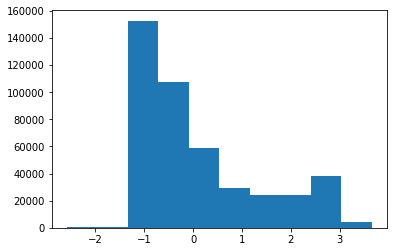

In [140]:
_ = plt.hist(normed_wordsense[0])

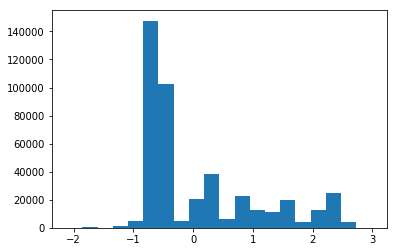

In [141]:
_ = plt.hist(np.minimum(np.maximum(normed_wordsense[0]/normed_wordsense[0].std(), -3), 3), bins=20)

In [146]:
wordsense['normed'] = np.minimum(np.maximum(normed_wordsense[0]/normed_wordsense[0].std(), -3), 3)

In [203]:
agg_by = ['Sentence.ID', 'Arg.Token', 'Arg.Lemma', 'Synset']

wordsense_agg = wordsense.pivot_table(index=agg_by, values='normed').reset_index()

wordsense_agg.head()

Sentence.ID  Arg.Token Arg.Lemma          Synset    normed
0  en-ud-dev.conllu 1          6     story        fib.n.01 -0.586071
1  en-ud-dev.conllu 1          6     story      floor.n.02 -0.586072
2  en-ud-dev.conllu 1          6     story    history.n.02  0.923774
3  en-ud-dev.conllu 1          6     story  narrative.n.01  0.923774
4  en-ud-dev.conllu 1          6     story     report.n.03  1.565103

In [204]:
supersenses = np.unique([synset.lexname() for synset in wn.all_synsets() if 'noun' in synset.lexname()])

supersenses

array(['noun.Tops', 'noun.act', 'noun.animal', 'noun.artifact',
       'noun.attribute', 'noun.body', 'noun.cognition',
       'noun.communication', 'noun.event', 'noun.feeling', 'noun.food',
       'noun.group', 'noun.location', 'noun.motive', 'noun.object',
       'noun.person', 'noun.phenomenon', 'noun.plant', 'noun.possession',
       'noun.process', 'noun.quantity', 'noun.relation', 'noun.shape',
       'noun.state', 'noun.substance', 'noun.time'], dtype='<U18')

In [205]:
def compute_supersenses(sense_dict):
    supersense_values = {'SUPERSENSE'+s: min([v for v in sense_dict.values()]) for s in supersenses}
    
    for sense, val in sense_dict.items():
        supsen = 'SUPERSENSE'+wn.synset(sense.replace('SENSE', '')).lexname()
            
        supersense_values[supsen] = max(supersense_values[supsen], val)
        
    return supersense_values

The one error below appears to be an actual error in the data.

In [206]:
wordsense_out = defaultdict(dict)

for (sentid, atokid, alemma), df in wordsense.groupby(agg_by[:-1]):
    fname, position = sentid.split()
    sentname = 'ewt-'+fname.split('.')[0].split('-')[2]+'-'+str(position)
    
    events = [e for e in predpatt[fname][sentname].events]
    argids = [int(a.position) for e in events for a in e.arguments]
    
    possiblesubarg = int(atokid-1) not in argids
    subargofarg = subargofpred = False
    preds = []
    
    #print(events[0].arguments, [a.tokens for a in events[0].arguments],  atokid, aword)
    if possiblesubarg:
        args = set([(a.position, len(a.tokens)) for e in events for a in e.arguments if atokid-1 in [t.position for t in a.tokens]])
        args = set([apos for apos, size in args if size==min([s for a, s in args])])
        subargofarg = len(args)==1
        
        #print('args', args, subargofarg)
        
        if not subargofarg:
            preds = set([e.position for e in events if (atokid-1) in [t.position for t in e.tokens]])
            subargofpred = len(preds)==1
            #print('preds', preds, subargofpred)
        
    if possiblesubarg and not subargofarg and not possiblesubarg:
        print(atokid-1, argids, (atokid-1) not in argids, type(atokid-1), [type(i) for i in argids])
        print('Error: no matching argument for', alemma, atokid, sentname, args, [a for e in events for a in e.arguments])
        continue

    sense_dict = df[['Synset', 'normed']].set_index('Synset').normed.to_dict()
    sense_dict = {'SENSE'+k: v for k, v in sense_dict.items()}
    #info = dict(sense_dict, **compute_supersenses(sense_dict))
    info = compute_supersenses(sense_dict)
    
    if subargofarg:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(argid, 'is subargof', sentname+'-semantics-arg-'+str(list(args)[0]+1))
        wordsense_out[sentname][argid]['subargof'] = sentname+'-semantics-arg-'+str(list(args)[0]+1)
    elif subargofpred:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(argid, 'is subargof', sentname+'-semantics-pred-'+str(list(preds)[0]+1))
        wordsense_out[sentname][argid]['subargof'] = sentname+'-semantics-pred-'+str(list(preds)[0]+1)
    elif possiblesubarg:
        argid = sentname+'-semantics-subarg-'+str(atokid)
        #wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}
        print(alemma, argid, [a for e in events for a in e.arguments])
    else:
        argid = sentname+'-semantics-arg-'+str(atokid)
        wordsense_out[sentname][argid] = {'wordsense-'+k: round(v, 4) for k, v in info.items()}

ewt-train-11045-semantics-subarg-46 is subargof ewt-train-11045-semantics-arg-11
ewt-train-11045-semantics-subarg-49 is subargof ewt-train-11045-semantics-arg-11
ewt-train-11682-semantics-subarg-24 is subargof ewt-train-11682-semantics-arg-5
ewt-train-12000-semantics-subarg-10 is subargof ewt-train-12000-semantics-arg-11
shop ewt-train-12136-semantics-subarg-23 [Argument(I/0), Argument(town/6), Argument(town/6), Argument(you/8), Argument(mechanic/13), Argument(you/8), Argument(I/24), Argument(Phet/29), Argument(are/35), Argument(mechanics/39)]
ewt-train-1385-semantics-subarg-15 is subargof ewt-train-1385-semantics-arg-2
ewt-train-6738-semantics-subarg-33 is subargof ewt-train-6738-semantics-arg-16
ewt-train-6764-semantics-subarg-22 is subargof ewt-train-6764-semantics-arg-5
ewt-train-7608-semantics-subarg-11 is subargof ewt-train-7608-semantics-pred-11
ewt-train-8314-semantics-subarg-10 is subargof ewt-train-8314-semantics-arg-8


In [160]:
print(predpatt['en-ud-train.conllu']['ewt-train-12139'].pprint())

	?a had been evaluating ?b for ?c
		?a: We
		?b: SEO providers
		?c: quite some time
	?a finally decided ?b
		?a: We
		?b: SOMETHING := to take the plunge with Stuart , and Ulistic
	?a take ?b
		?a: We
		?b: the plunge with Stuart , and Ulistic


In [161]:
predpatt['en-ud-train.conllu']['ewt-train-12139'].events[1].arguments

[Argument(We/0), Argument(take/14)]

In [188]:
wordsense_out

defaultdict(dict,
            {'ewt-dev-1': {'ewt-dev-1-semantics-arg-6': {'wordsense-SUPERSENSEnoun.Tops': -0.5861,
               'wordsense-SUPERSENSEnoun.act': -0.5861,
               'wordsense-SUPERSENSEnoun.animal': -0.5861,
               'wordsense-SUPERSENSEnoun.artifact': -0.5861,
               'wordsense-SUPERSENSEnoun.attribute': -0.5861,
               'wordsense-SUPERSENSEnoun.body': -0.5861,
               'wordsense-SUPERSENSEnoun.cognition': -0.5861,
               'wordsense-SUPERSENSEnoun.communication': 1.5651,
               'wordsense-SUPERSENSEnoun.event': -0.5861,
               'wordsense-SUPERSENSEnoun.feeling': -0.5861,
               'wordsense-SUPERSENSEnoun.food': -0.5861,
               'wordsense-SUPERSENSEnoun.group': -0.5861,
               'wordsense-SUPERSENSEnoun.location': -0.5861,
               'wordsense-SUPERSENSEnoun.motive': -0.5861,
               'wordsense-SUPERSENSEnoun.object': -0.5861,
               'wordsense-SUPERSENSEnoun.person':

In [207]:
with open('../data/wordsense/wordsense.json', 'w') as f:
    json.dump(wordsense_out, f)